In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import scipy.special
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['-1', '0', '1'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    # centre the x ticks
    ax.set_xticks(np.arange(len(class_names)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(class_names)+1)-.5, minor=True)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("bottom")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [4]:
# Load dataset
df = pd.read_feather("../Data/Data145_NoClean.feather")

# Map numerical sentiment values to categorical labels
sentiment_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

# Combine text, company names, and base URLs for processing
X = df[['text', 'base_url']]
X_combined = X['text'] + ' <EOF> ' + X['base_url']

In [5]:
# Load tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [6]:
# List to store predicted sentiment scores
scores = []

# Process the combined text for sentiment analysis
for i, text in enumerate(X_combined):
    # Tokenize the text and convert to PyTorch tensors
    inputs = tokenizer(text, max_length=512, truncation=True, return_tensors="pt")
    with torch.no_grad():
        # Get model logits
        logits = model(**inputs).logits
        # Convert logits to probabilities using softmax
        probability_scores = scipy.special.softmax(logits.numpy().squeeze())
        # Create a dictionary of label to probability mappings
        score = {k: v for k, v in zip(model.config.id2label.values(), probability_scores)}
        scores.append(score)
    
    # Calculate progress percentage and print
    progress = 100 * (i + 1) / len(X_combined)
    print(f"Progress: {progress:.2f}% - Item {i} - Predicted Probabilities: {score} - '{text}'")

Progress: 0.00% - Item 0 - Predicted Probabilities: {'positive': 0.037241615, 'negative': 0.038088538, 'neutral': 0.92466986} - 'VIDEO: “I was in my office. I was minding my own business...” –David Solomon tells $GS interns how he learned he wa… https://t.co/QClAITywXV <EOF> twitter.com'
Progress: 0.01% - Item 1 - Predicted Probabilities: {'positive': 0.008645418, 'negative': 0.9518362, 'neutral': 0.039518327} - 'The price of lumber $LB_F is down 22% since hitting its YTD highs. The Macy's $M turnaround is still happening.… https://t.co/XnKsV4De39 <EOF> twitter.com'
Progress: 0.01% - Item 2 - Predicted Probabilities: {'positive': 0.022068853, 'negative': 0.12513632, 'neutral': 0.85279477} - 'Who says the American Dream is dead? https://t.co/CRgx19x7sA <EOF> buff.ly'
Progress: 0.02% - Item 3 - Predicted Probabilities: {'positive': 0.09622479, 'negative': 0.022387212, 'neutral': 0.88138795} - 'Barry Silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrant

In [7]:
# Create a new DataFrame from the scores
df_scores = pd.concat([df, pd.DataFrame(scores)], axis=1)

# Save the DataFrame to a new feather file
df_scores.to_feather("../Data/Data145_NoClean_OpenLLMPredicted_Probabilities.feather")

In [8]:
# calculate accuracy
predicted_sentiments = df_scores[['negative', 'neutral', 'positive']].idxmax(axis=1)
accuracy = np.mean(df['sentiment'] == predicted_sentiments)

Accuracy: 0.5619842084132578

Classification Report:
               precision    recall  f1-score   support

    negative       0.37      0.35      0.36      2462
     neutral       0.61      0.82      0.70     13025
    positive       0.43      0.16      0.23      6930

    accuracy                           0.56     22417
   macro avg       0.47      0.44      0.43     22417
weighted avg       0.53      0.56      0.52     22417


Confusion Matrix:
 [[  853  1529    80]
 [ 1012 10645  1368]
 [  450  5380  1100]]


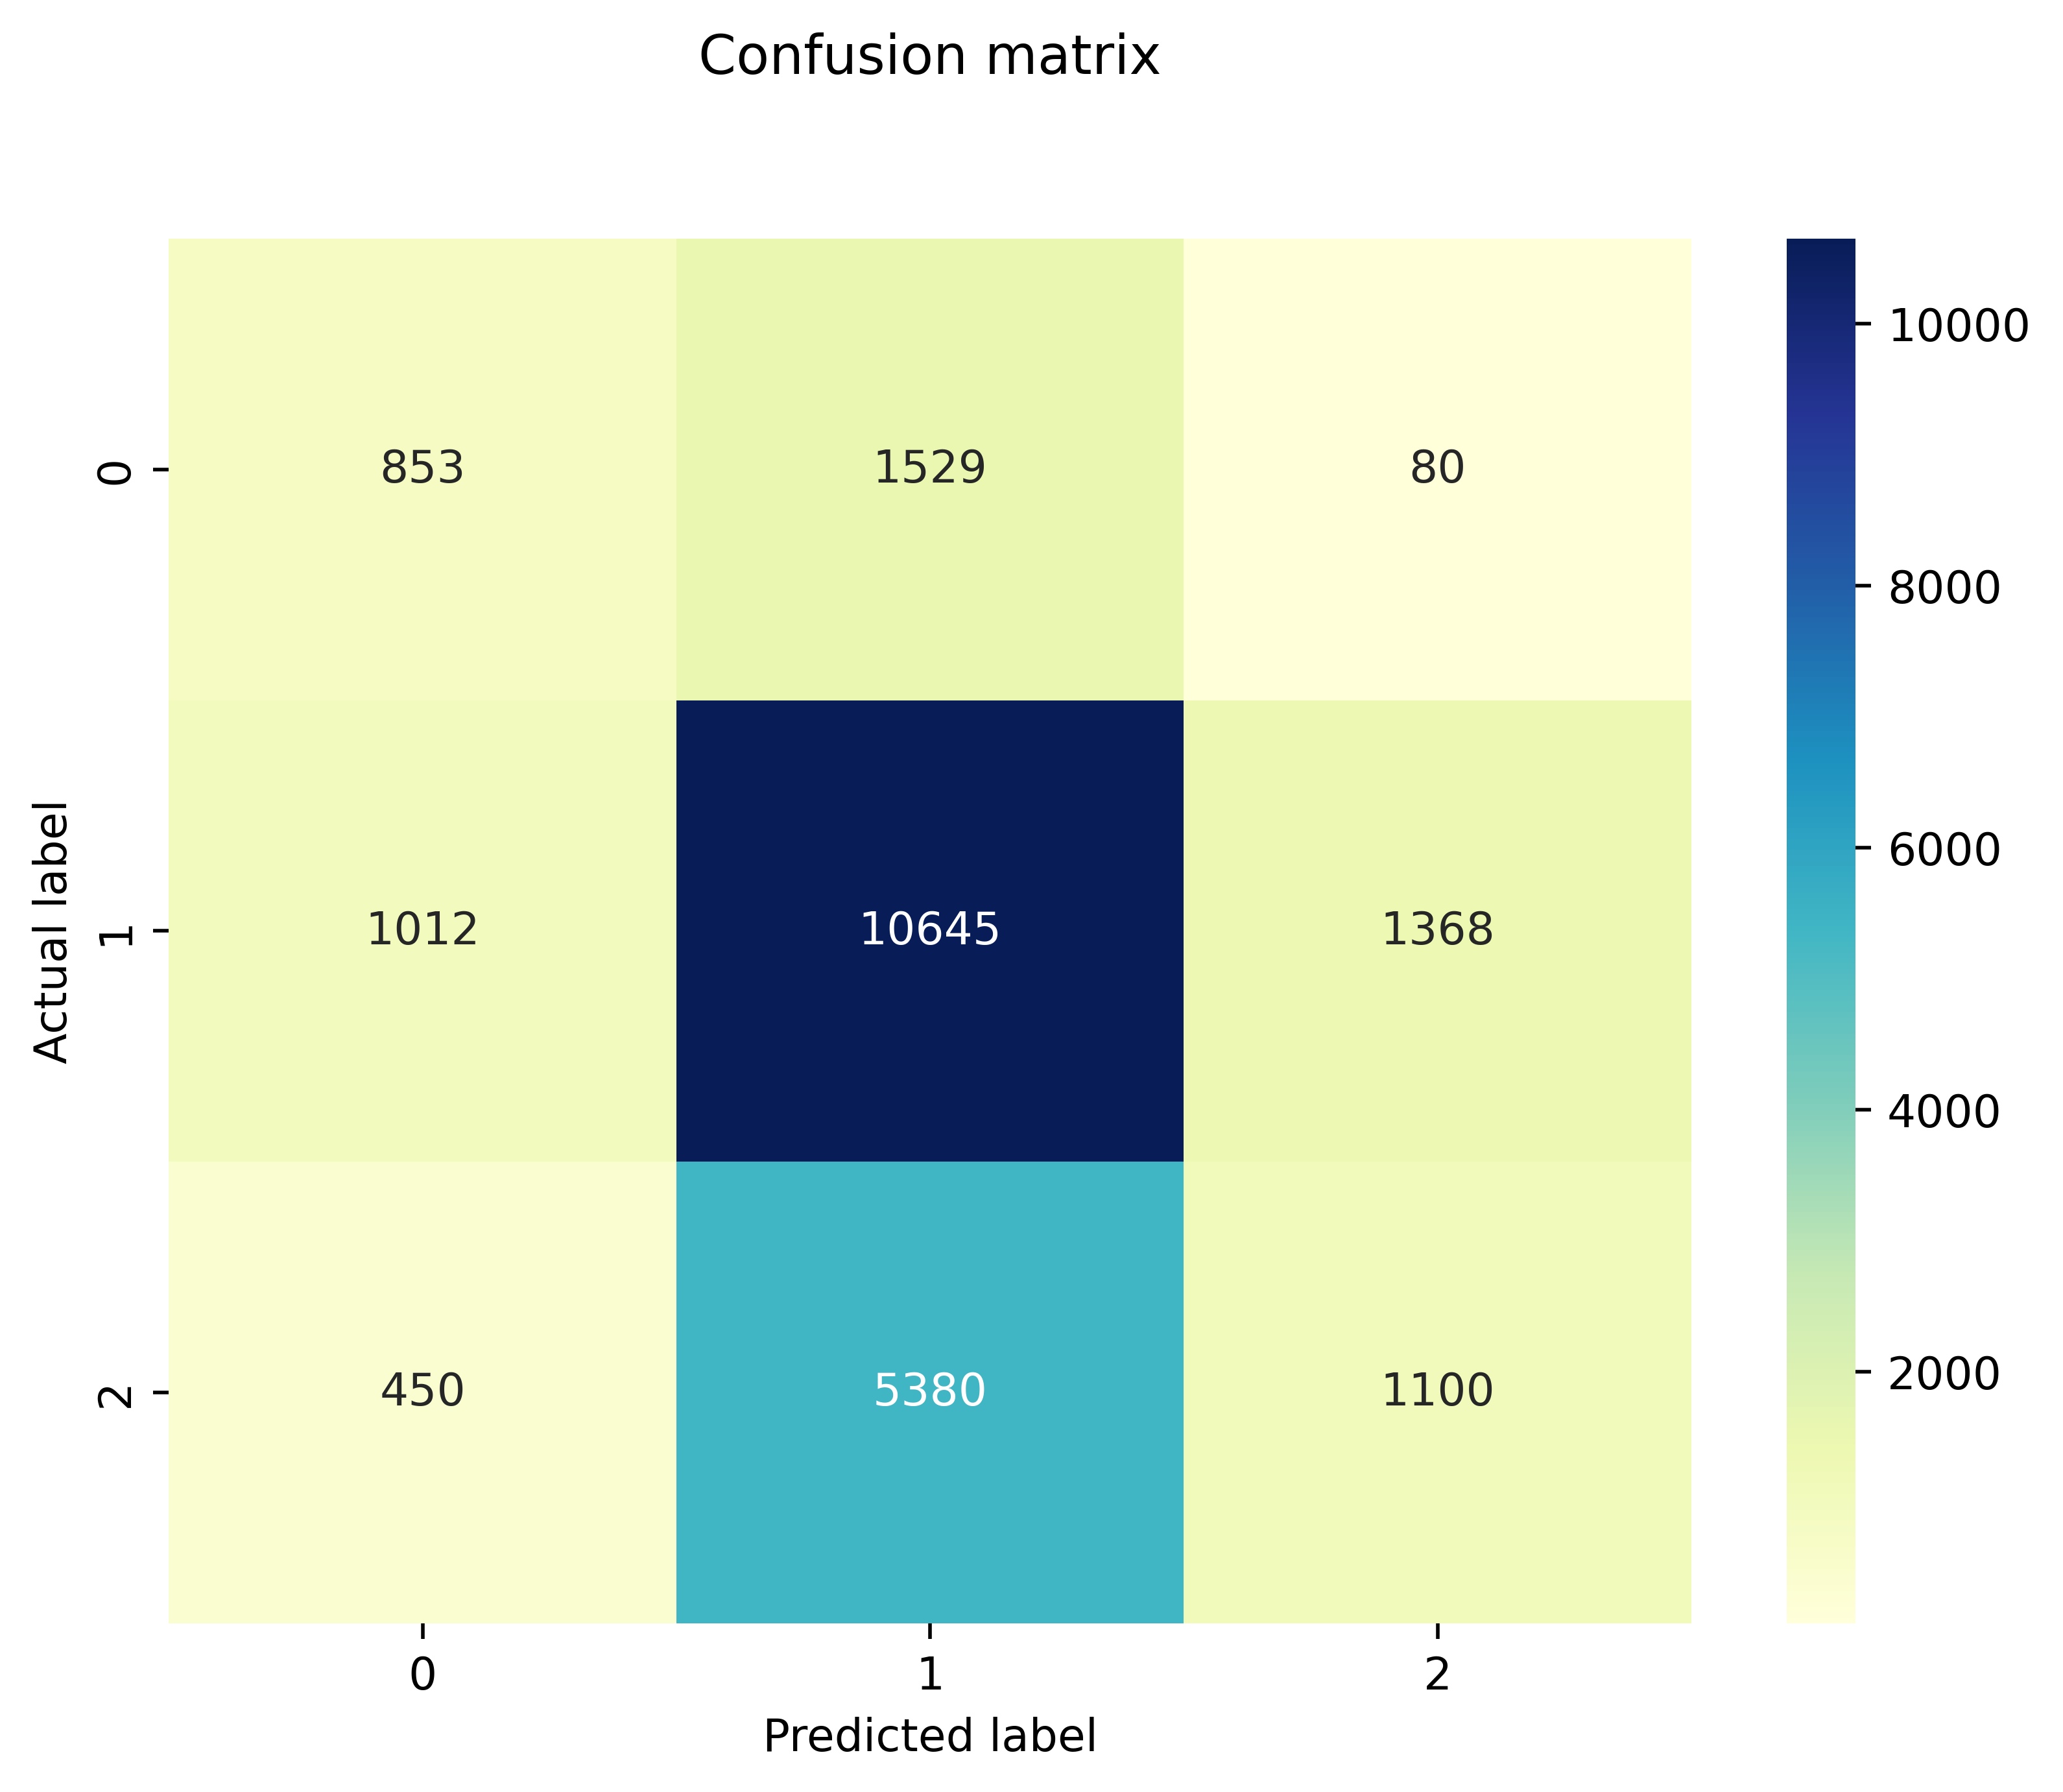

In [9]:
print(f"Accuracy: {accuracy}")

# Generate and print a classification report
print("\nClassification Report:\n", classification_report(df['sentiment'], predicted_sentiments))

# Generate a confusion matrix
confusion_mat = confusion_matrix(df['sentiment'], predicted_sentiments)

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_mat)

# Plotting the confusion matrix
plot_conf_mat(confusion_mat)